In [1]:
import polars as pl
import numpy as np
from scipy.special import expit
import seaborn as sns
from matplotlib import pyplot as plt
from plotnine import *
from cycler import cycler

In [2]:
data = pl.read_csv("../data/xmas_sales.csv", infer_schema_length=1000)
data.head(6)

store,weeks_to_xmas,avg_week_sales,is_on_sale,weekly_amount_sold
i64,i64,f64,i64,f64
1,3,12.98,1,219.6
1,2,12.98,1,184.7
1,1,12.98,1,145.75
1,0,12.98,0,102.45
2,3,19.92,0,103.22
2,2,19.92,0,53.73


In [3]:
data = data.with_columns(
	pl.when(pl.col("is_on_sale") == 0)
	  .then(pl.lit("no"))
	  .otherwise(pl.lit("yes"))
	  .alias("is_on_sale")
	  .cast(pl.Categorical)
)
data

store,weeks_to_xmas,avg_week_sales,is_on_sale,weekly_amount_sold
i64,i64,f64,cat,f64
1,3,12.98,"""yes""",219.6
1,2,12.98,"""yes""",184.7
1,1,12.98,"""yes""",145.75
1,0,12.98,"""no""",102.45
2,3,19.92,"""no""",103.22
…,…,…,…,…
499,0,23.1,"""yes""",15.6
500,3,20.52,"""no""",154.68
500,2,20.52,"""no""",93.52


### Tratamiento y Resultado

En este análisis, el **tratamiento** ($T$) para cada unidad $i$ se define como:

- $T_i = 1$ si la unidad $i$ recibió el tratamiento (por ejemplo, una rebaja de precio, representada por la columna $\texttt{is\_on\_sale}$)
- $T_i = 0$ en caso contrario

El término "tratamiento" no se limita a la medicina; aquí se refiere a cualquier intervención cuyo efecto queremos medir. En este caso, el tratamiento es una rebaja de precio para un negocio en la plataforma.

A veces, el tratamiento se denota como $D$ en lugar de $T$, especialmente cuando hay una dimensión temporal, para evitar confusiones.

El **resultado** o **outcome** es la variable que queremos influenciar, en este caso $\texttt{weekly\_amount\_sold}$ (cantidad vendida semanalmente), denotada como $Y_i$.

**Objetivo del análisis causal:**  
Determinar el impacto que tiene el tratamiento ($T$ o $\texttt{is\_on\_sale}$) sobre el resultado ($Y$ o $\texttt{weekly\_amount\_sold}$).

$$
T_i = 
\begin{cases}
1 & \text{si la unidad } i \text{ recibió el tratamiento} \\
0 & \text{en caso contrario}
\end{cases}
$$

$$
Y_i = \text{weekly\_amount\_sold}
$$

## The Fundamental Problem of Causal Inference

El problema fundamental de la inferencia causal es que nunca podemos observar el mismo negocio (unidad) simultáneamente con y sin tratamiento. Solo vemos lo que ocurre bajo una de las dos condiciones posibles, pero no ambas a la vez. Por ejemplo, aunque los datos muestran que las tiendas en rebaja venden mucho más, esto no necesariamente implica causalidad: puede haber otros factores, como el tamaño del negocio o la cercanía a Navidad, que expliquen la diferencia. Para conocer el verdadero efecto de las rebajas, necesitaríamos comparar el mismo negocio, en el mismo momento, con y sin rebaja, lo cual es imposible. Por eso, la inferencia causal requiere métodos adicionales para aproximar este escenario contrafactual y evitar confundir asociación con causalidad.

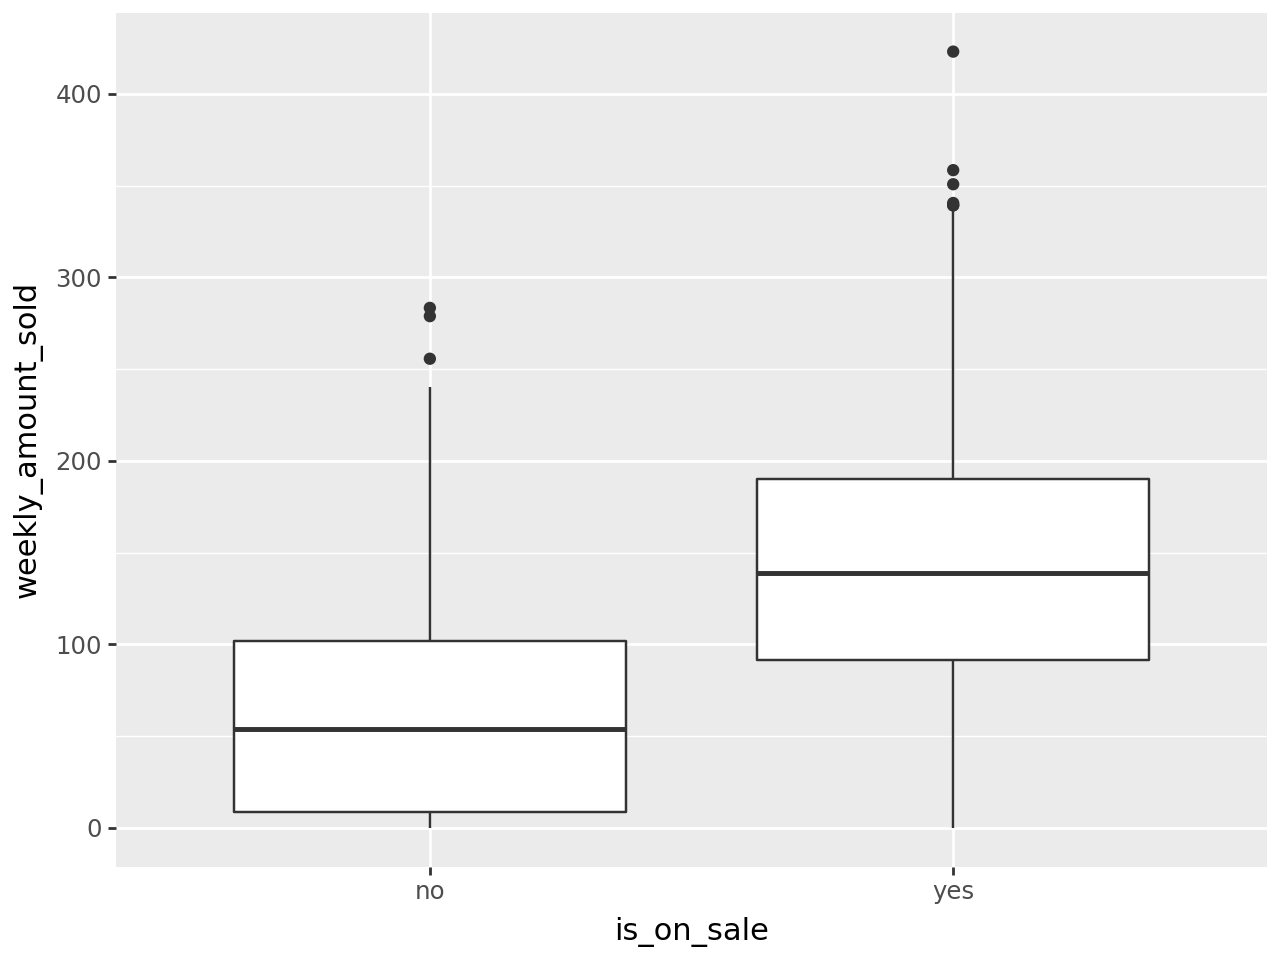

In [4]:
(
    ggplot(data, aes(x="is_on_sale", y="weekly_amount_sold"))
    + geom_boxplot()
)

## Modelos Causales: Resumen y Formalización

Un **modelo causal** es una representación formal de cómo ciertas variables (endógenas) son determinadas por otras variables y factores externos (exógenos). Utilizamos funciones para expresar estas relaciones y distinguir entre variables que modelamos explícitamente y aquellas que dejamos fuera del modelo.

### Notación Formal

- Variables **exógenas** ($u$): factores externos no modelados explícitamente.
- Variables **endógenas**: aquellas que sí modelamos y nos interesan.

Por ejemplo, un modelo causal simple para el efecto de una rebaja en ventas semanales sería:

$$
\begin{align*}
T &\leftarrow f_T(u_t) \\
Y &\leftarrow f_Y(T, u_y)
\end{align*}
$$

Donde:
- $T$ es el tratamiento (por ejemplo, si hay rebaja: $\texttt{is\_on\_sale}$).
- $Y$ es el resultado ($\texttt{weekly\_amount\_sold}$).
- $u_t$ y $u_y$ son variables exógenas que afectan a $T$ y $Y$, respectivamente.

Esto significa que $T$ es causado por factores externos $u_t$, y $Y$ es causado tanto por $T$ como por otros factores $u_y$.

### Ejemplo con Variables Adicionales

Si creemos que el tamaño del negocio ($\texttt{BusinessSize}$) también influye, el modelo se expande:

$$
\begin{align*}
S &\leftarrow f_S(u_s) \\
T &\leftarrow f_T(S, u_t) \\
Y &\leftarrow f_Y(T, S, u_y)
\end{align*}
$$

Donde:
- $S$ es el tamaño del negocio.
- $T$ (rebaja) depende de $S$ y $u_t$.
- $Y$ (ventas) depende de $T$, $S$ y $u_y$.

Así, $S$ es causa común de $T$ y $Y$.

### Comparación con Modelos Estadísticos

En estadística, esto suele representarse como una regresión lineal:

$$
\text{AmountSold}_i = \alpha + \beta_1 \cdot \text{IsOnSale}_i + \beta_2 \cdot \text{BusinessSize}_i + e_i
$$

- Aquí, $\alpha$ es la constante, $\beta_1$ y $\beta_2$ son los coeficientes, y $e_i$ es el error.
- Este modelo asume una relación lineal y aditiva entre las variables.

### Puntos Clave

- Los modelos causales permiten razonar explícitamente sobre cómo se generan las variables.
- La notación con flechas ($\leftarrow$) enfatiza la direccionalidad y la no reversibilidad de la causalidad.
- Incluir más variables endógenas en el modelo permite explicar mejor las relaciones y evitar confusiones entre asociación y causalidad.

## Intervetions

Las **intervenciones** en modelos causales consisten en modificar directamente una variable (por ejemplo, forzar el tratamiento $T$ a un valor específico $t_0$), ignorando sus causas naturales. Esto se representa formalmente con el operador $\text{do}()$, introducido por Judea Pearl. El objetivo es responder preguntas del tipo: “¿Qué pasaría con el resultado $Y$ si forzamos $T = t_0$?”

Por ejemplo, en un modelo causal simple:

$$
\begin{align*}
T &\leftarrow f_T(u_t) \\
Y &\leftarrow f_Y(T, u_y)
\end{align*}
$$

Una intervención $\text{do}(T = t_0)$ reemplaza la ecuación de $T$ por $T = t_0$, eliminando la influencia de $u_t$:

$$
\begin{align*}
T &= t_0 \\
Y &\leftarrow f_Y(T, u_y)
\end{align*}
$$

Esto nos permite calcular el efecto causal de $T$ sobre $Y$.

El valor esperado (o expectativa) de una variable aleatoria $X$ se denota como $\mathbb{E}[X]$ y representa el promedio poblacional. Si queremos saber el valor esperado de $Y$ dado que $X = x$, lo escribimos como $\mathbb{E}[Y \mid X = x]$.

Cuando intervenimos, usamos la notación $\mathbb{E}[Y \mid \text{do}(T = t_0)]$, que significa: “el valor esperado de $Y$ si forzamos $T$ a $t_0$ mediante una intervención”.

En resumen:

- $\mathbb{E}[X]$: esperanza marginal de $X$ (promedio poblacional).
- $\mathbb{E}[Y \mid X = x]$: esperanza condicional de $Y$ dado $X = x$ (promedio de $Y$ para los casos donde $X = x$).
- $\mathbb{E}[Y \mid \text{do}(T = t_0)]$: esperanza de $Y$ bajo la intervención $T = t_0$ (efecto causal de $T$ sobre $Y$).

---

El operador $\text{do}()$ también ilustra por qué la asociación es diferente de la causalidad. Por ejemplo, el promedio de ventas para negocios que hicieron una rebaja, $\mathbb{E}[\text{AmountSold} \mid \text{IsOnSale} = 1]$, puede sobrestimar el efecto promedio que tendría una rebaja si la aplicáramos a todos los negocios, $\mathbb{E}[\text{AmountSold} \mid \text{do}(\text{IsOnSale} = 1)]$. En el primer caso, observamos negocios que eligieron hacer rebajas (probablemente los más grandes), mientras que en el segundo caso, forzamos a todos los negocios a hacer rebajas y medimos el efecto en toda la muestra.

En general:

$$
\mathbb{E}[\text{AmountSold} \mid \text{IsOnSale} = 1] \neq \mathbb{E}[\text{AmountSold} \mid \text{do}(\text{IsOnSale} = 1)]
$$

La diferencia radica en la **selección** versus la **intervención**: al condicionar en ventas, medimos sobre un subconjunto seleccionado de negocios que realmente hicieron rebajas; al intervenir con $\text{do}()$, forzamos la rebaja en todos y medimos sobre toda la muestra.

El operador $\text{do}()$ define cantidades causales que no siempre son observables directamente en los datos. Por ejemplo, no podemos observar $\text{do}(\text{IsOnSale} = 1)$ para todos los negocios, ya que no forzamos a todos a hacer rebajas. Por eso, gran parte de la inferencia causal consiste en encontrar formas de identificar (eliminar) el operador $\text{do}()$ de las expresiones teóricas usando los datos observados.

### Efecto Individual del Tratamiento (ITE)

El operador $\text{do}()$ también permite expresar el **efecto individual del tratamiento** (Individual Treatment Effect, ITE), que es el impacto del tratamiento sobre el resultado para una unidad específica. Formalmente, se define como la diferencia entre dos intervenciones:

$$
\tau_i = Y_i\big|_{\text{do}(T = t_1)} - Y_i\big|_{\text{do}(T = t_0)}
$$

En palabras: el efecto para la unidad $i$ es la diferencia en el resultado de esa unidad bajo tratamiento $t_1$ comparado con $t_0$.

En el contexto de nuestro problema, esto se traduce en el efecto de cambiar $\texttt{IsOnSale}$ de 0 a 1 en $\texttt{AmountSold}$:

$$
\tau_i = \text{AmountSold}_i\big|_{\text{do}(\text{IsOnSale} = 1)} - \text{AmountSold}_i\big|_{\text{do}(\text{IsOnSale} = 0)}
$$

Debido al problema fundamental de la inferencia causal, solo podemos observar uno de los dos términos anteriores para cada unidad: nunca vemos el mismo negocio simultáneamente con y sin rebaja. Por eso, aunque el ITE es una cantidad teórica bien definida, en la práctica necesitamos métodos estadísticos para estimarlo usando los datos observados.

1. **Consistencia**

**Explicación sencilla (nivel básico):**  
Imagina que quieres saber el efecto de dar un cupón a los clientes. Si defines el tratamiento como “recibir un cupón”, pero en realidad hay varios tipos de cupones (por ejemplo, 10%, 20%, 50% de descuento), entonces no estás siendo consistente. La **consistencia** significa que, para cada persona, el resultado potencial bajo un tratamiento específico ($Y_i(t)$) es exactamente el que observarías si esa persona realmente recibe ese tratamiento.

**Notación formal:**  
$$
Y_i = Y_i(t) \quad \text{si} \quad T_i = t
$$

Es decir, el resultado observado para el individuo $i$ es igual a su resultado potencial bajo el tratamiento que realmente recibió.

**Ejemplo:**  
Si solo consideras “recibió cupón” vs “no recibió”, pero en realidad hay diferentes valores de descuento, violas la consistencia.  
Otro ejemplo: “recibió ayuda financiera” puede significar muchas cosas (una llamada, asesoría continua, etc.). Si agrupas todo como un solo tratamiento, pierdes consistencia.

**¿Cómo tratar violaciones?**
- Define claramente todas las versiones del tratamiento.
- Si hay diferentes dosis o tipos, inclúyelos explícitamente en el análisis.

---

2. **SUTVA (No Interferencia)**

**Explicación sencilla (nivel básico):**  
SUTVA significa que lo que le pasa a una persona no depende de lo que les pasa a los demás. Por ejemplo, si vacunas a una persona, eso no debería afectar el resultado de otra persona. Pero en la vida real, a veces sí afecta (por ejemplo, con enfermedades contagiosas).

**Notación formal:**  
$$
Y_i(T_1, T_2, ..., T_n) = Y_i(T_i)
$$

Esto significa que el resultado potencial de la unidad $i$ solo depende de su propio tratamiento, no del tratamiento asignado a otros.

---

**Pregunta de revisión:**  
¿Puedes pensar en un1. **Consistencia**

**Explicación sencilla:**  
Imagina que quieres medir el efecto de entregar un cupón a los clientes. Si defines el tratamiento como “recibir un cupón”, pero en realidad existen varios tipos de cupones (por ejemplo, 10%, 20%, 50% de descuento), entonces no estás siendo consistente. La **consistencia** significa que, para cada persona, el resultado potencial bajo un tratamiento específico ($Y_i(t)$) es exactamente el que observarías si esa persona realmente recibe ese tratamiento.

**Notación formal:**  
$$
Y_i = Y_i(t) \quad \text{si} \quad T_i = t
$$

Es decir, el resultado observado para el individuo $i$ es igual a su resultado potencial bajo el tratamiento que realmente recibió.

**Ejemplo:**  
Si solo consideras “recibió cupón” vs “no recibió”, pero en realidad hay diferentes valores de descuento, se viola la consistencia.  
Otro ejemplo: “recibió apoyo” puede significar diferentes acciones (una llamada, asesoría, etc.). Si agrupas todo como un solo tratamiento, pierdes consistencia.

**¿Cómo tratar violaciones?**
- Define claramente todas las versiones del tratamiento.
- Si hay diferentes dosis o tipos, inclúyelos explícitamente en el análisis.

---

2. **SUTVA (No Interferencia)**

**Explicación sencilla:**  
SUTVA significa que lo que le sucede a una persona no depende de lo que les sucede a los demás. Por ejemplo, si aplicas un tratamiento a una persona, eso no debería afectar el resultado de otra persona. Sin embargo, en algunos contextos, esto puede no cumplirse.

**Notación formal:**  
$$
Y_i(T_1, T_2, ..., T_n) = Y_i(T_i)
$$

Esto significa que el resultado potencial de la unidad $i$ solo depende de su propio tratamiento, no del tratamiento asignado a otros.




### Tipos de Efectos Causales: Resumen Formal y Conceptual

#### 1. **Efecto Promedio del Tratamiento (ATE)**

**Definición formal:**
$$
ATE = \mathbb{E}[\tau_i] = \mathbb{E}[Y_i(1) - Y_i(0)]
$$

**Con do-cálculo:**
$$
ATE = \mathbb{E}[Y \mid do(T=1)] - \mathbb{E}[Y \mid do(T=0)]
$$

**Interpretación:**  
El ATE mide el efecto promedio que tendría el tratamiento si lo aplicáramos a toda la población. Es útil para estimar el impacto global de una política o intervención.

---

#### 2. **Efecto Promedio del Tratamiento en los Tratados (ATT)**

**Definición formal:**
$$
ATT = \mathbb{E}[Y_i(1) - Y_i(0) \mid T=1]
$$

**Interpretación:**  
El ATT mide el efecto promedio del tratamiento solo en aquellos que realmente lo recibieron. Por ejemplo, si una campaña se aplicó en una ciudad, el ATT estima el beneficio promedio para esa ciudad.

---

#### 3. **Efecto Promedio del Tratamiento Condicional (CATE)**

**Definición formal:**
$$
CATE(x) = \mathbb{E}[Y_i(1) - Y_i(0) \mid X = x]
$$

**Interpretación:**  
El CATE permite analizar cómo varía el efecto del tratamiento según características específicas ($X$), como edad, género o nivel socioeconómico. Es fundamental para personalización y segmentación.

---

#### 4. **Tratamiento Continuo**

**Definición formal:**
$$
\frac{\partial}{\partial t} \mathbb{E}[Y_i \mid T = t]
$$

**Interpretación:**  
Cuando el tratamiento es continuo (por ejemplo, porcentaje de descuento), esta derivada mide cuánto cambia el resultado esperado ante pequeños cambios en la intensidad del tratamiento.

---

#### **Resumen Visual**

- **ATE:** ¿Qué pasa en promedio si todos reciben el tratamiento?
- **ATT:** ¿Qué pasa en promedio entre los que sí recibieron el tratamiento?
- **CATE:** ¿Cómo cambia el efecto según las características de los individuos?
- **Tratamiento continuo:** ¿Cómo cambia el resultado ante pequeños cambios en la intensidad del tratamiento?

In [5]:
df = pl.DataFrame({
    "i": [1,2,3,4,5,6],
    "y0": [200,120,300, 450,600,600],
    "y1": [220,140,400, 500,600,800],
    "t": [0,0,0,1,1,1],
    "x": [0,0,1,0,0,1],
}).with_columns([
    (pl.col("t") * pl.col("y1") + (1 - pl.col("t")) * pl.col("y0")).alias("y"),
    (pl.col("y1") - pl.col("y0")).alias("te")
])

In [6]:
ate = df.select(pl.col("te").mean()).item()
ate

65.0

In [7]:
att = df.filter(pl.col("t") == 1).select(pl.col("te").mean()).item()
att

83.33333333333333

In [8]:
cate_x1 = df.filter(pl.col("x") == 1).select(pl.col("te").mean()).item()
cate_x1

150.0

In [9]:
cate_x0 = df.filter(pl.col("x") == 0).select(pl.col("te").mean()).item()
cate_x0

22.5

## Real World

In [10]:
df = pl.DataFrame({
    "i": [1,2,3,4,5,6],
    "y0": [200,120,300, None, None, None],
    "y1": [None, None, None, 500,600,800],
    "t": [0,0,0,1,1,1],
    "x": [0,0,1,0,0,1],
}).with_columns([
    # Selecciona y1 si t==1, y y0 si t==0 (esto es el resultado observado)
    pl.when(pl.col("t") == 1).then(pl.col("y1")).otherwise(pl.col("y0")).alias("y"),
    # Calcula el efecto individual del tratamiento (ITE)
    (pl.col("y1") - pl.col("y0")).alias("te")
])
df

i,y0,y1,t,x,y,te
i64,i64,i64,i64,i64,i64,i64
1,200,null,0,0,200,null
2,120,null,0,0,120,null
3,300,null,0,1,300,null
4,null,500,1,0,500,null
5,null,600,1,0,600,null
6,null,800,1,1,800,null


## Bias
 
### The Bias Equation 


 
### A Visual Guide to Bias
 

### Visualizando el sesgo y la no intercambiabilidad (exchangeability)

La siguiente gráfica muestra cómo el tamaño del negocio (medido por `avg_week_sales`) está relacionado tanto con el tratamiento (`is_on_sale`) como con el resultado (`weekly_amount_sold`).

Observa que los negocios tratados (con rebaja) tienden a ser más grandes y vender más, incluso antes de aplicar el tratamiento. Esto genera un sesgo: la diferencia observada entre grupos no es sólo efecto del tratamiento, sino también de diferencias preexistentes.

Las líneas horizontales marcan el promedio de ventas semanales para cada grupo.

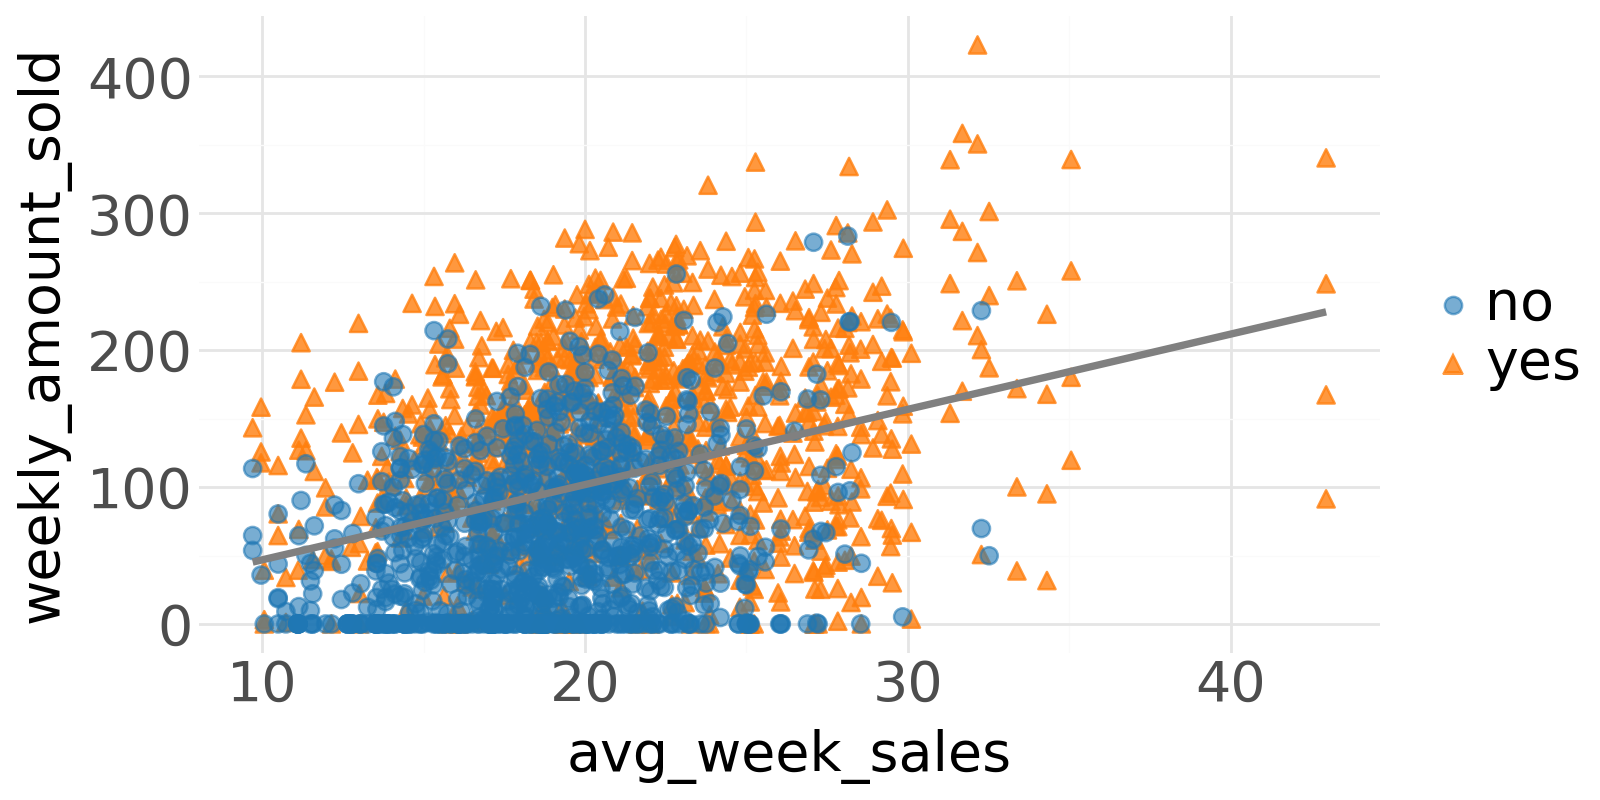

In [15]:
import polars as pl
from plotnine import *

# Preprocesamiento igual que antes
df_plot = data.with_columns(
    pl.col("is_on_sale")
    .cast(pl.Utf8)
    .replace({"1": "on sale", "0": "not on sale"})
    .alias("status")
)

(
    # 1. AES GLOBAL: Solo definimos X e Y.
    # NO ponemos color aquí para que geom_smooth use todos los datos juntos.
    ggplot(df_plot, aes(x="avg_week_sales", y="weekly_amount_sold"))
    
    # 2. PUNTOS: Aquí sí especificamos color y forma por grupo
    + geom_point(aes(color="status", shape="status", alpha="status"), size=3)
    
    # 3. LÍNEA: Como no hay color en el aes global, hace una regresión única
    + geom_smooth(method="lm", se=False, color="gray", size=1.5) 
    
    # 4. Personalización (igual que antes)
    + scale_color_manual(values=["#1f77b4", "#ff7f0e"])
    + scale_shape_manual(values=["o", "^"])
    + scale_alpha_manual(values=[0.6, 0.8])
    + theme_minimal()
    + theme(
        figure_size=(8, 4),
        text=element_text(size=20),
        legend_title=element_blank()
    )
)

### Resumen: Lenguaje Matemático de la Inferencia Causal

#### 1. **Resultados Potenciales (Potential Outcomes)**
- **Idea central:** Para cada unidad (persona, tienda, etc.), existen múltiples resultados posibles, uno para cada valor del tratamiento ($T$).
- **Notación:** $Y_i(t)$ es el resultado que observaríamos en la unidad $i$ si recibiéramos el tratamiento $T = t$.
- **Ejemplo:** Si $T$ es "recibir descuento" ($T=1$) o "no recibir descuento" ($T=0$), entonces:
    - $Y_i(1)$: Ventas de la tienda $i$ con descuento.
    - $Y_i(0)$: Ventas de la tienda $i$ sin descuento.

---

#### 2. **Diferencia entre Asociación y Causalidad**
- **Problema:** Si los grupos tratados y no tratados son diferentes por razones ajenas al tratamiento, comparar sus medias no revela el efecto causal real.
- **Matemáticamente:** Si $E[Y_0 \mid T=1] \neq E[Y_0 \mid T=0]$, la comparación está sesgada.
- **Ejemplo:** Si las tiendas grandes tienden a hacer descuentos y además venden más, la diferencia de ventas refleja tanto el efecto del descuento como el tamaño de la tienda (confusión).

---

#### 3. **Condición de Independencia (Exchangeability)**
- **Clave:** Para identificar el efecto causal, los resultados potenciales deben ser independientes del tratamiento asignado:
    $$
    Y_0, Y_1 \perp T
    $$
- **En experimentos aleatorizados:** Esta independencia se logra por diseño.

---

#### 4. **Estimador de Diferencia de Medias**
- **Fórmula:**
    $$
    E[Y_1 - Y_0] = E[Y \mid T=1] - E[Y \mid T=0]
    $$
- **Validez:** Solo es válido si los grupos son comparables (independencia).

---

#### 5. **Supuestos Clave**
1. **Independencia del tratamiento:** $T \perp Y_t$ (el tratamiento es como lanzar una moneda).
2. **SUTVA:** El tratamiento de una unidad no afecta a otra.
3. **Consistencia:** El resultado observado es igual al potencial bajo el tratamiento recibido.

---

#### 6. **Función de Switch**
- **Cómo se observa el resultado real:**
    $$
    Y_i = (1 - T_i)Y_{0i} + T_iY_{1i}
    $$
- **Interpretación:** Solo vemos uno de los dos resultados potenciales para cada unidad.

---

#### 7. **Importancia de los Supuestos**
- **Causalidad ≠ Asociación:** Siempre se necesitan supuestos para pasar de la pregunta causal ("¿qué pasaría si...?") al estimador estadístico ("¿qué calculo con los datos?").
- **Sin supuestos:** No es posible identificar el efecto causal solo con los datos observados.